# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-1.257260,True,3.352305
1,0.837915,True,6.346178
2,-0.249020,False,-1.862087
3,-0.590371,True,3.457127
4,0.887002,True,7.542029
...,...,...,...
995,0.277364,True,7.077200
996,2.326230,True,12.787867
997,0.168356,True,5.664070
998,-0.364923,False,-0.328857


<AxesSubplot:xlabel='v0'>

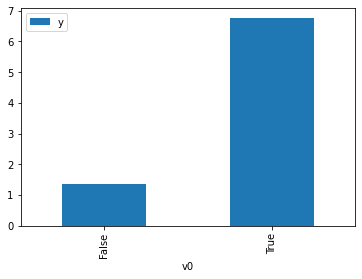

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

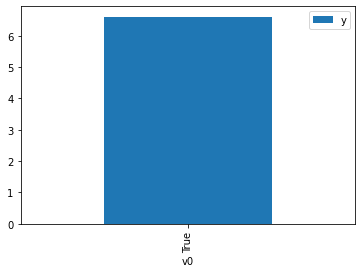

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.051015,False,0.381437,0.483529,2.068129
1,-1.613068,False,-4.710927,0.645239,1.549814
2,1.773018,False,4.067163,0.320145,3.123585
3,1.427421,False,4.207830,0.350876,2.850006
4,1.480886,False,4.493874,0.346032,2.889903
...,...,...,...,...,...
995,1.480886,False,4.493874,0.346032,2.889903
996,0.114514,False,-0.413207,0.477204,2.095541
997,0.535401,False,-0.345827,0.435558,2.295908
998,1.230471,False,3.198157,0.368981,2.710169


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.124302,True,6.310779,0.523771,1.909232
1,2.008046,True,13.605664,0.699916,1.428743
2,1.108871,True,8.051774,0.619651,1.613813
3,1.785742,True,8.911968,0.680959,1.468517
4,0.115524,True,5.176355,0.522897,1.912423
...,...,...,...,...,...
995,-0.553558,True,2.921157,0.456272,2.191673
996,1.661085,True,9.315044,0.670056,1.492413
997,0.614121,True,5.708205,0.572149,1.747795
998,0.499723,True,6.550809,0.560939,1.782725


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.973
Model:                            OLS   Adj. R-squared (uncentered):              0.973
Method:                 Least Squares   F-statistic:                          1.783e+04
Date:                Sat, 13 Aug 2022   Prob (F-statistic):                        0.00
Time:                        02:40:48   Log-Likelihood:                         -1419.7
No. Observations:                1000   AIC:                                      2843.
Df Residuals:                     998   BIC:                                      2853.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.8072      0.032     86.813      0.000       2.744       2.871
x2             5.1060      0.048    106.488      0.000       5.012       5.200
==============================================================================
Omnibus:                        1.373   Durbin-Watson:                   2.041
Prob(Omnibus):                  0.503   Jarque-Bera (JB):                1.274
Skew:                           0.026   Prob(JB):                        0.529
Kurtosis:                       3.167   Cond. No.                         1.93
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""